In [10]:
import spacy
import pandas as pd
from neo4j import GraphDatabase

nlp = spacy.load('en_core_web_sm')
df = pd.read_csv("technical_company_data.csv")


In [11]:
patterns = [
    {"label": "PERSON", "pattern": name} for name in [
        "Elon Musk", "Steve Jobs", "Mark Zuckerberg", "Jeff Bezos",
        "Sundar Pichai", "Larry Page", "Sergey Brin", "Bill Gates",
        "Satya Nadella", "Tim Cook", "Sam Altman", "Arvind Krishna",
        "Jensen Huang", "Jack Dorsey", "Lisa Su", "Pat Gelsinger",
        "Sam Altman", "Jensen Huang", "Lisa Su", "Pat Gelsinger", "Arvind Krishna"
    ]
] + [
    {"label": "ORG", "pattern": org} for org in [
        "Tesla", "SpaceX", "Neuralink", "The Boring Company", "Apple", "Pixar",
        "Facebook", "Amazon", "Google", "Microsoft", "OpenAI", "IBM", "NVIDIA",
        "Twitter", "Meta", "Intel", "AMD"
    ]
] + [
    {"label": "GPE", "pattern": loc} for loc in [
        "California", "Cupertino", "Menlo Park", "Seattle", "Mountain View", 
        "Redmond", "Santa Clara"
    ]
] + [
    {"label": "DATE", "pattern": [{"SHAPE": "dddd"}]}  # 年份
]

nlp.add_pipe("entity_ruler", before="ner").add_patterns(patterns)

In [12]:
for index, row in df.iterrows():
    doc1, doc2 = nlp(row["Entity1"]), nlp(row["Entity2"])
    print([(ent.text, ent.label_) for ent in doc1.ents], row["Relationship"], [(ent.text, ent.label_) for ent in doc2.ents])

[('Elon Musk', 'PERSON')] CEO of [('Tesla', 'ORG')]
[('Elon Musk', 'PERSON')] CEO of [('SpaceX', 'ORG')]
[('Elon Musk', 'PERSON')] Founder of [('Neuralink', 'ORG')]
[('Elon Musk', 'PERSON')] Founder of [('The Boring Company', 'ORG')]
[('Steve Jobs', 'PERSON')] Co-founder of [('Apple', 'ORG')]
[('Steve Jobs', 'PERSON')] Co-founder of [('Pixar', 'ORG')]
[('Mark Zuckerberg', 'PERSON')] Founder of [('Facebook', 'ORG')]
[('Jeff Bezos', 'PERSON')] Founder of [('Amazon', 'ORG')]
[('Jeff Bezos', 'PERSON')] CEO of [('Amazon', 'ORG')]
[('Sundar Pichai', 'PERSON')] CEO of [('Google', 'ORG')]
[('Larry Page', 'PERSON')] Co-founder of [('Google', 'ORG')]
[('Sergey Brin', 'PERSON')] Co-founder of [('Google', 'ORG')]
[('Bill Gates', 'PERSON')] Founder of [('Microsoft', 'ORG')]
[('Bill Gates', 'PERSON')] CEO of [('Microsoft', 'ORG')]
[('Satya Nadella', 'PERSON')] CEO of [('Microsoft', 'ORG')]
[('Tim Cook', 'PERSON')] CEO of [('Apple', 'ORG')]
[('Tesla', 'ORG')] Founded in [('2003', 'DATE')]
[('SpaceX',

In [13]:
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "whf1324568"))

def create_node(tx,name,label):
    tx.run(f"MERGE(:{label}{{name:$name}})",name = name)

def create_relationship(tx,ent1,rel,ent2):
    tx.run("""
        MERGE (a:Entity {name:$entity1})
        MERGE (b:Entity {name:$entity2})
        MERGE (a)-[:RELATION {type: $relation}]->(b)
    """, entity1 = ent1,entity2=ent2,relation = rel)

In [14]:
with driver.session() as session:
    for index, row in df.iterrows():
        ent1,rel,ent2 = row["Entity1"], row["Relationship"],row["Entity2"]
        session.execute_write(create_node,ent1,"Entity")
        session.execute_write(create_node,ent2,"Entity")
        session.execute_write(create_relationship,ent1,rel,ent2)

driver.close()
print("Success")

Success


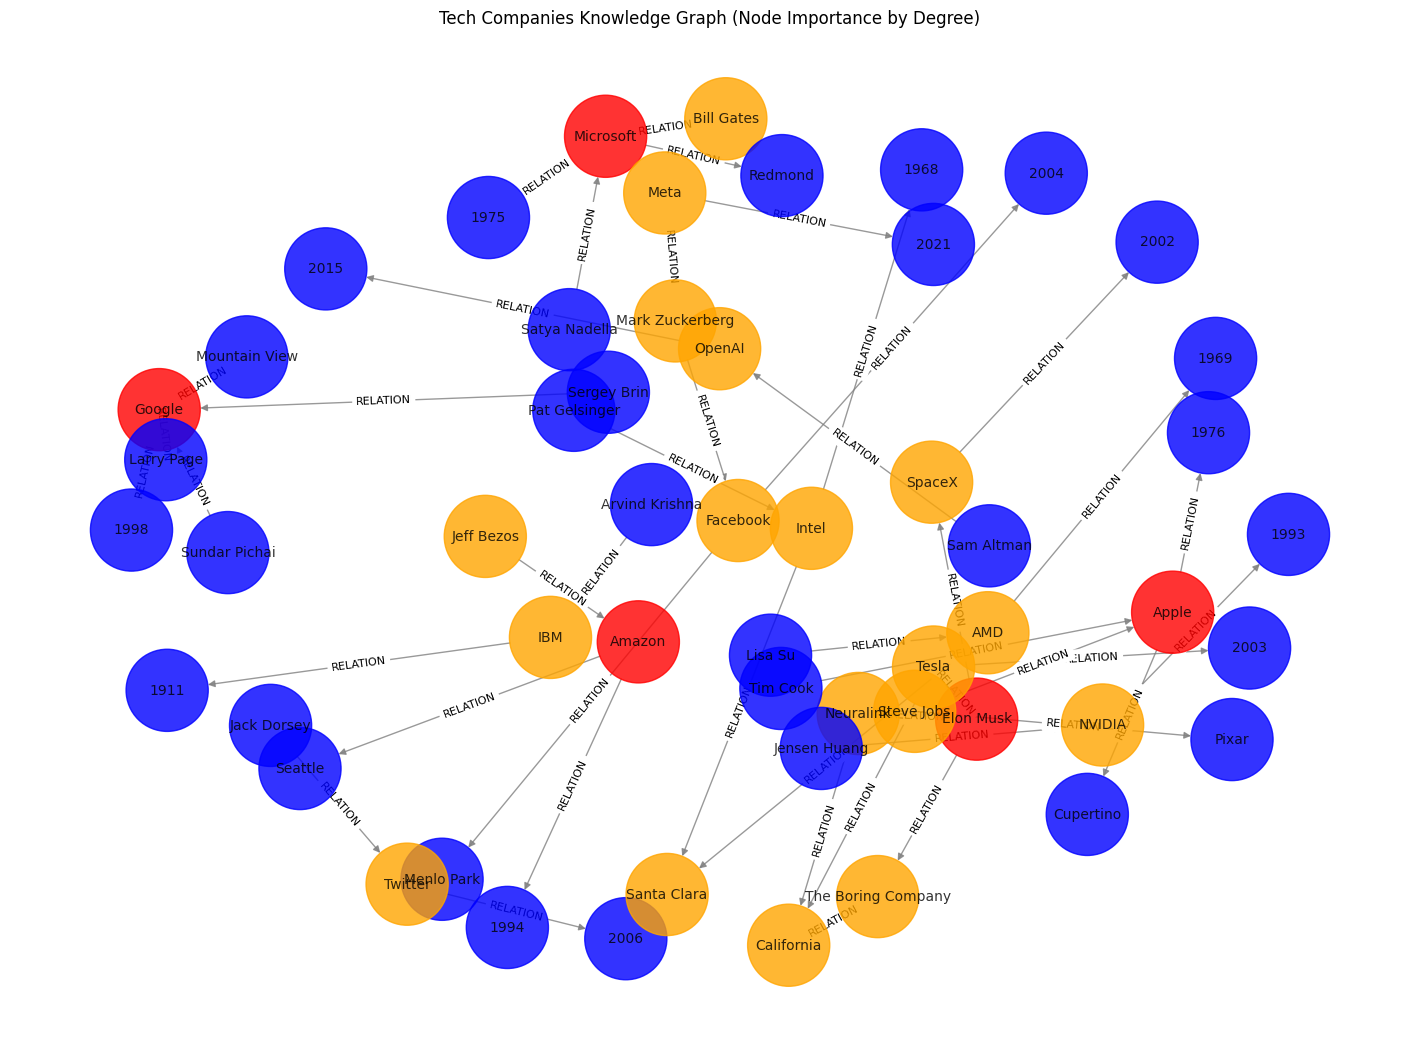

In [ ]:
from py2neo import Graph
import networkx as nx
import matplotlib.pyplot as plt

# 连接Neo4j数据库
graph = Graph("bolt://localhost:7687", auth=("neo4j", "whf1324568"))

# 正确更新节点的degree属性（连边数量）
graph.run("""
MATCH (n)
SET n.degree = COUNT{(n)--()}
""")

# 获取节点和关系信息
query = """
MATCH (a)-[r]->(b)
RETURN a.name AS source, a.degree AS source_degree, 
       type(r) AS relation, 
       b.name AS target, b.degree AS target_degree
"""
data = graph.run(query).data()

# 构建NetworkX图谱
G = nx.DiGraph()

# 添加节点和边，附带节点度信息
for item in data:
    G.add_node(item['source'], degree=item['source_degree'])
    G.add_node(item['target'], degree=item['target_degree'])
    G.add_edge(item['source'], item['target'], relation=item['relation'])

# 根据节点的连边数指定颜色
colors = []
for node in G.nodes(data=True):
    degree = node[1]['degree']
    if degree >= 4:
        colors.append('red')  # 高度重要节点
    elif degree >= 2:
        colors.append('orange')
    else:
        colors.append('blue')

# 绘制知识图谱
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=3500, font_size=10, node_color=colors, edge_color='gray', alpha=0.8)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['relation'] for u, v, d in G.edges(data=True)}, font_size=8)

plt.title("Tech Companies Knowledge Graph (Node Importance by Degree)")
plt.show()